In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 20, 4
rcParams['figure.dpi'] = 500
rcParams.update({'font.size': 16})

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [2]:
def dist(x, y):
    """
    Euclidean distance between matrix and vector
    """
    return (((x - y)**2).sum(1))**0.5

class RealNVP(nn.Module):
    """
    This code is based on the github reposetory: https://github.com/senya-ashukha/real-nvp-pytorch.
    
    A simple implementation for RealNVP.
    inputs:
     - nets, a neural netwerk that learns the sacaling for each coupling layer.
     - nett, a neural netwerk that learns the translating for each coupling layer.
     - mask, this determines which part of the data undergoes the afine projection and which is used as inputs for nett and nets.
     - prior, the prior used for the latent space representation.
    """
    def __init__(self, nets, nett, mask, prior):
        super().__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
        # nn.Parameters has to be used to prevent memory leaks.
        self.prev_data = None
        self.prev_label = None

    def f(self, x):      
        """
        forward function for RealNVP.        
        """
        log_det_J = x.new_zeros(x.shape[0])
        for translate, scale, mask in zip(self.t, self.s, self.mask):
            x1 = y1 = x * mask
            x2 = x * (1 - mask)
            s = scale(x1) * (1 - mask)
            t = translate(x1) * (1 - mask)
            y2 = x2 * torch.exp(s) + t
            x = y1 + y2
            log_det_J += s.sum(dim=1)
        y = x
        return y, log_det_J

    def g(self, y):
        """
        Reverse function of the forward.
        """
        for translate, scale, mask in zip(reversed(self.t), reversed(self.s), reversed(self.mask)):
            y1 = x1 = y * mask
            y2 = y * (1 - mask)
            s = scale(y1) * (1 - mask)
            t = translate(y1) * (1 - mask)
            x2 = (y2 - t) * torch.exp(-s)
            y = x1 + x2
        x = y
        return x
    
    def log_prob(self, x):
        """
        log probability of the data fitting the prior plus the log jacobian.
        """
        y, logp = self.f(x)
        return self.prior.log_prob(y) + logp, y
    
    def train_latent_space(self, z, label):
        """
        Previous seen data is used in nearest neighbour to determine which point belongs to which class during sampling.
        This function saves encoded original (latent space) data including the labels.
        """
        with torch.no_grad():
            try:
                self.prev_data.copy_(z)
                self.prev_label.copy_(label)
            except (AttributeError, RuntimeError):
                self.prev_data = nn.Parameter(z, requires_grad=False)
                self.prev_label = nn.Parameter(label, requires_grad=False)
      
    def sample(self, batchSize):
        """
        Sample from prior using Nearest Neighbor to determine the class using prev data.
        """
        y = self.prior.sample((batchSize, 1))
        x = self.g(y)
        l = np.array([bool(self.prev_label[np.argmin(dist(self.prev_data,s))].item()) for s in y])
        return x[l],x[~l],y[l],y[~l]

In [3]:
hdim = 256
nets = lambda: nn.Sequential(nn.Linear(2, hdim), nn.LeakyReLU(), nn.Linear(hdim, hdim), nn.LeakyReLU(), nn.Linear(hdim, 2), nn.Sigmoid())
"""
nets (net scale)
nets nodes: 2 input nodes, hdim hidden nodes, hdim hidden nodes, 2 output nodes
activations are Relu and last Tanh.
"""
nett = lambda: nn.Sequential(nn.Linear(2, hdim), nn.LeakyReLU(), nn.Linear(hdim, hdim), nn.LeakyReLU(), nn.Linear(256, 2))
"""
nett (net translation)
nett nodes: 2 input nodes, hdim hidden nodes, hdim hidden nodes, 2 output nodes
activations are Relu and no end activation. 
"""
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32)) #6 coupling layers alternating
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2)) #2D gaussian no correlations
flow = RealNVP(nets, nett, masks, prior)

In [4]:
"""
The model is trained by first 10000 iterations with lr 1e-4 and then 5000 iterations using 1e-5 as learning rate.
"""
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(10001):    
    noisy_moons, label = datasets.make_moons(n_samples=64, noise=.05)
    label = torch.from_numpy(label)
    x = torch.from_numpy(noisy_moons.astype(np.float32))
    loss, z = flow.log_prob(x)
    loss = -loss.mean()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
        
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-5)
for t in range(10001, 15001):    
    noisy_moons, label = datasets.make_moons(n_samples=64, noise=.05)
    label = torch.from_numpy(label)
    x = torch.from_numpy(noisy_moons.astype(np.float32))
    loss, z = flow.log_prob(x)
    loss = -loss.mean()
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
        
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

# Save data in the model to determine the labels during sampling with nearest neighbour.
noisy_moons, label = datasets.make_moons(n_samples=1024, noise=.05)
label = torch.from_numpy(label)
x = torch.from_numpy(noisy_moons.astype(np.float32))
loss, z = flow.log_prob(x)
flow.train_latent_space(z, label)


iter 0: loss = 12.503
iter 500: loss = 0.853
iter 1000: loss = 0.583
iter 1500: loss = 0.742
iter 2000: loss = 0.788
iter 2500: loss = 0.474
iter 3000: loss = 0.700
iter 3500: loss = 0.484
iter 4000: loss = 0.558
iter 4500: loss = 0.601
iter 5000: loss = 0.544
iter 5500: loss = 0.535
iter 6000: loss = 0.690
iter 6500: loss = 0.468
iter 7000: loss = 0.701
iter 7500: loss = 0.591
iter 8000: loss = 0.557
iter 8500: loss = 0.456
iter 9000: loss = 0.379
iter 9500: loss = 0.544
iter 10000: loss = 0.480
iter 10500: loss = 0.337
iter 11000: loss = 0.412
iter 11500: loss = 0.482
iter 12000: loss = 0.526
iter 12500: loss = 0.380
iter 13000: loss = 0.469
iter 13500: loss = 0.332
iter 14000: loss = 0.169
iter 14500: loss = 0.520
iter 15000: loss = 0.403


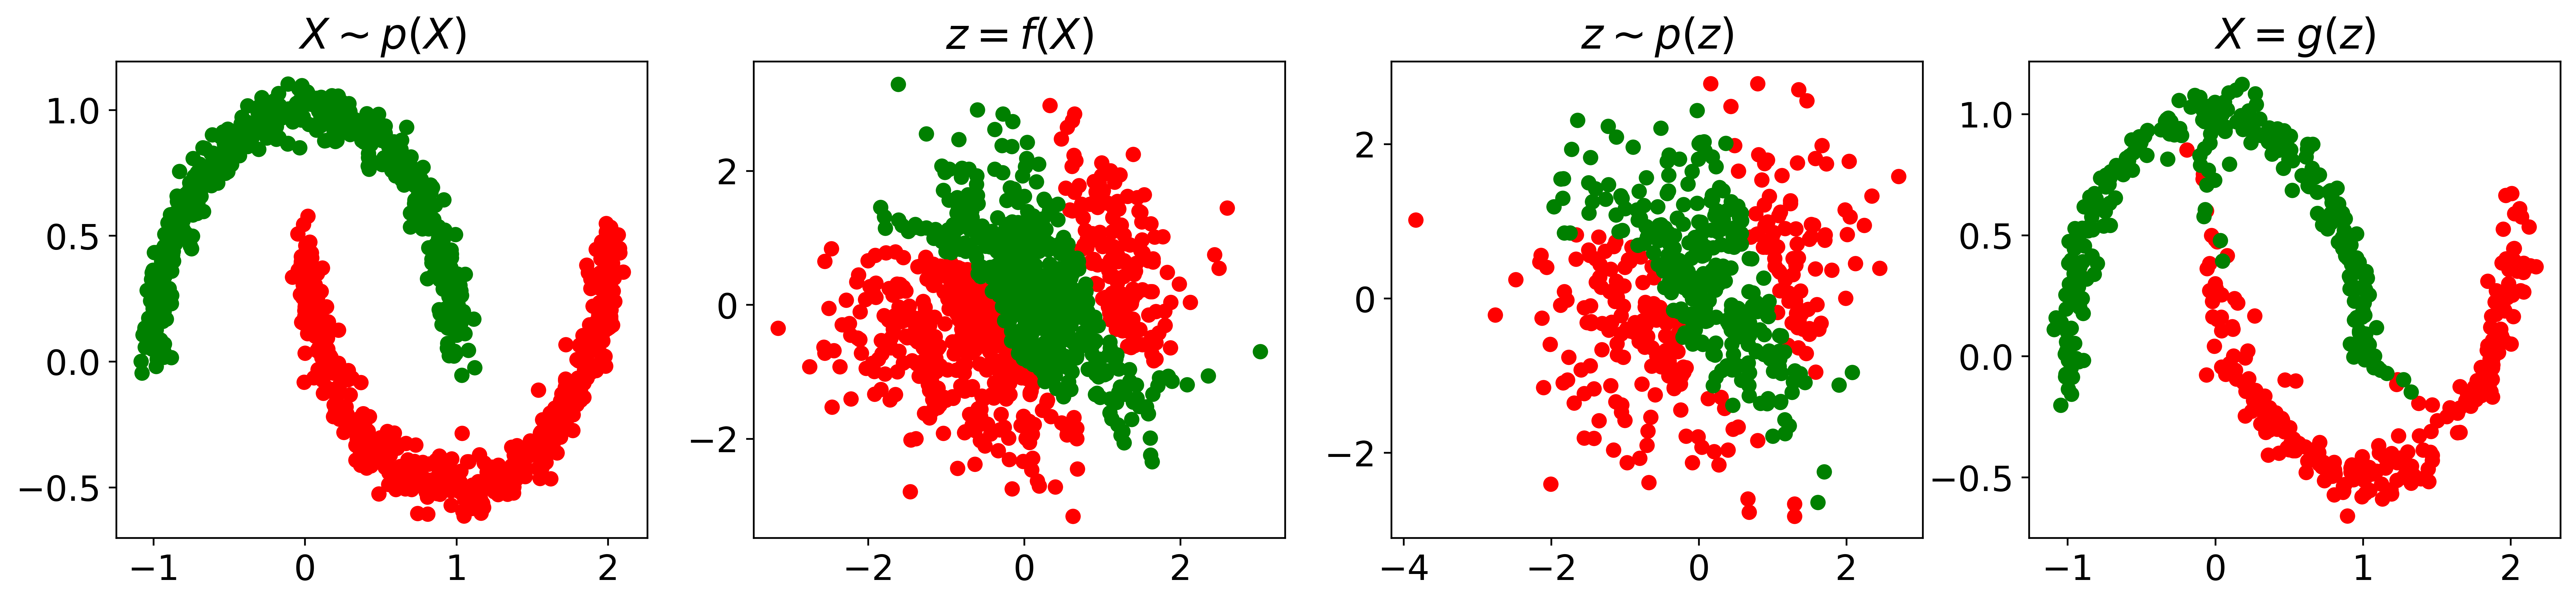

In [5]:
rcParams['figure.figsize'] = 20, 4

# Generate synthetic data for the plots.
noisy_moons, label = datasets.make_moons(n_samples=1000, noise=.05)
u = torch.zeros((1000,2))
l = torch.from_numpy(label)
u[:,0] = l
u[:,1] = 1-l
label = label.astype(bool)

# plot the original data X
plt.subplot(141)
x, y = datasets.make_moons(n_samples=1000, noise=.05)
x = x.astype(np.float32)
y = y.astype(bool)
plt.scatter(x[y, 0], x[y, 1], c='r')
plt.scatter(x[~y, 0], x[~y, 1], c='g')
plt.title(r'$X \sim p(X)$')

# plot the latent space after encoding the data using model.f(x)
z = flow.f(torch.from_numpy(noisy_moons.astype(np.float32)))[0].detach().numpy()
plt.subplot(142)
plt.scatter(z[label, 0], z[label, 1], c='r')
plt.scatter(z[~label, 0], z[~label, 1], c='g')
plt.title(r'$z = f(X)$')

# plot generated latent space points using the prior distribution.
plt.subplot(143)
x0, x1, y0, y1 = flow.sample(500)
x0 = x0.detach().numpy()
x1 = x1.detach().numpy()
y0 = y0.detach().numpy()
y1 = y1.detach().numpy()
plt.scatter(y0[:, 0, 0], y0[:, 0, 1], c='r')
plt.scatter(y1[:, 0, 0], y1[:, 0, 1], c='g')
plt.title(r'$z \sim p(z)$')

# plot the decoded generated latent space points in the orginal space.
plt.subplot(144)
plt.scatter(x0[:, 0, 0], x0[:, 0, 1], c='r')
plt.scatter(x1[:, 0, 0], x1[:, 0, 1], c='g')
plt.title(r'$X = g(z)$')
plt.show()

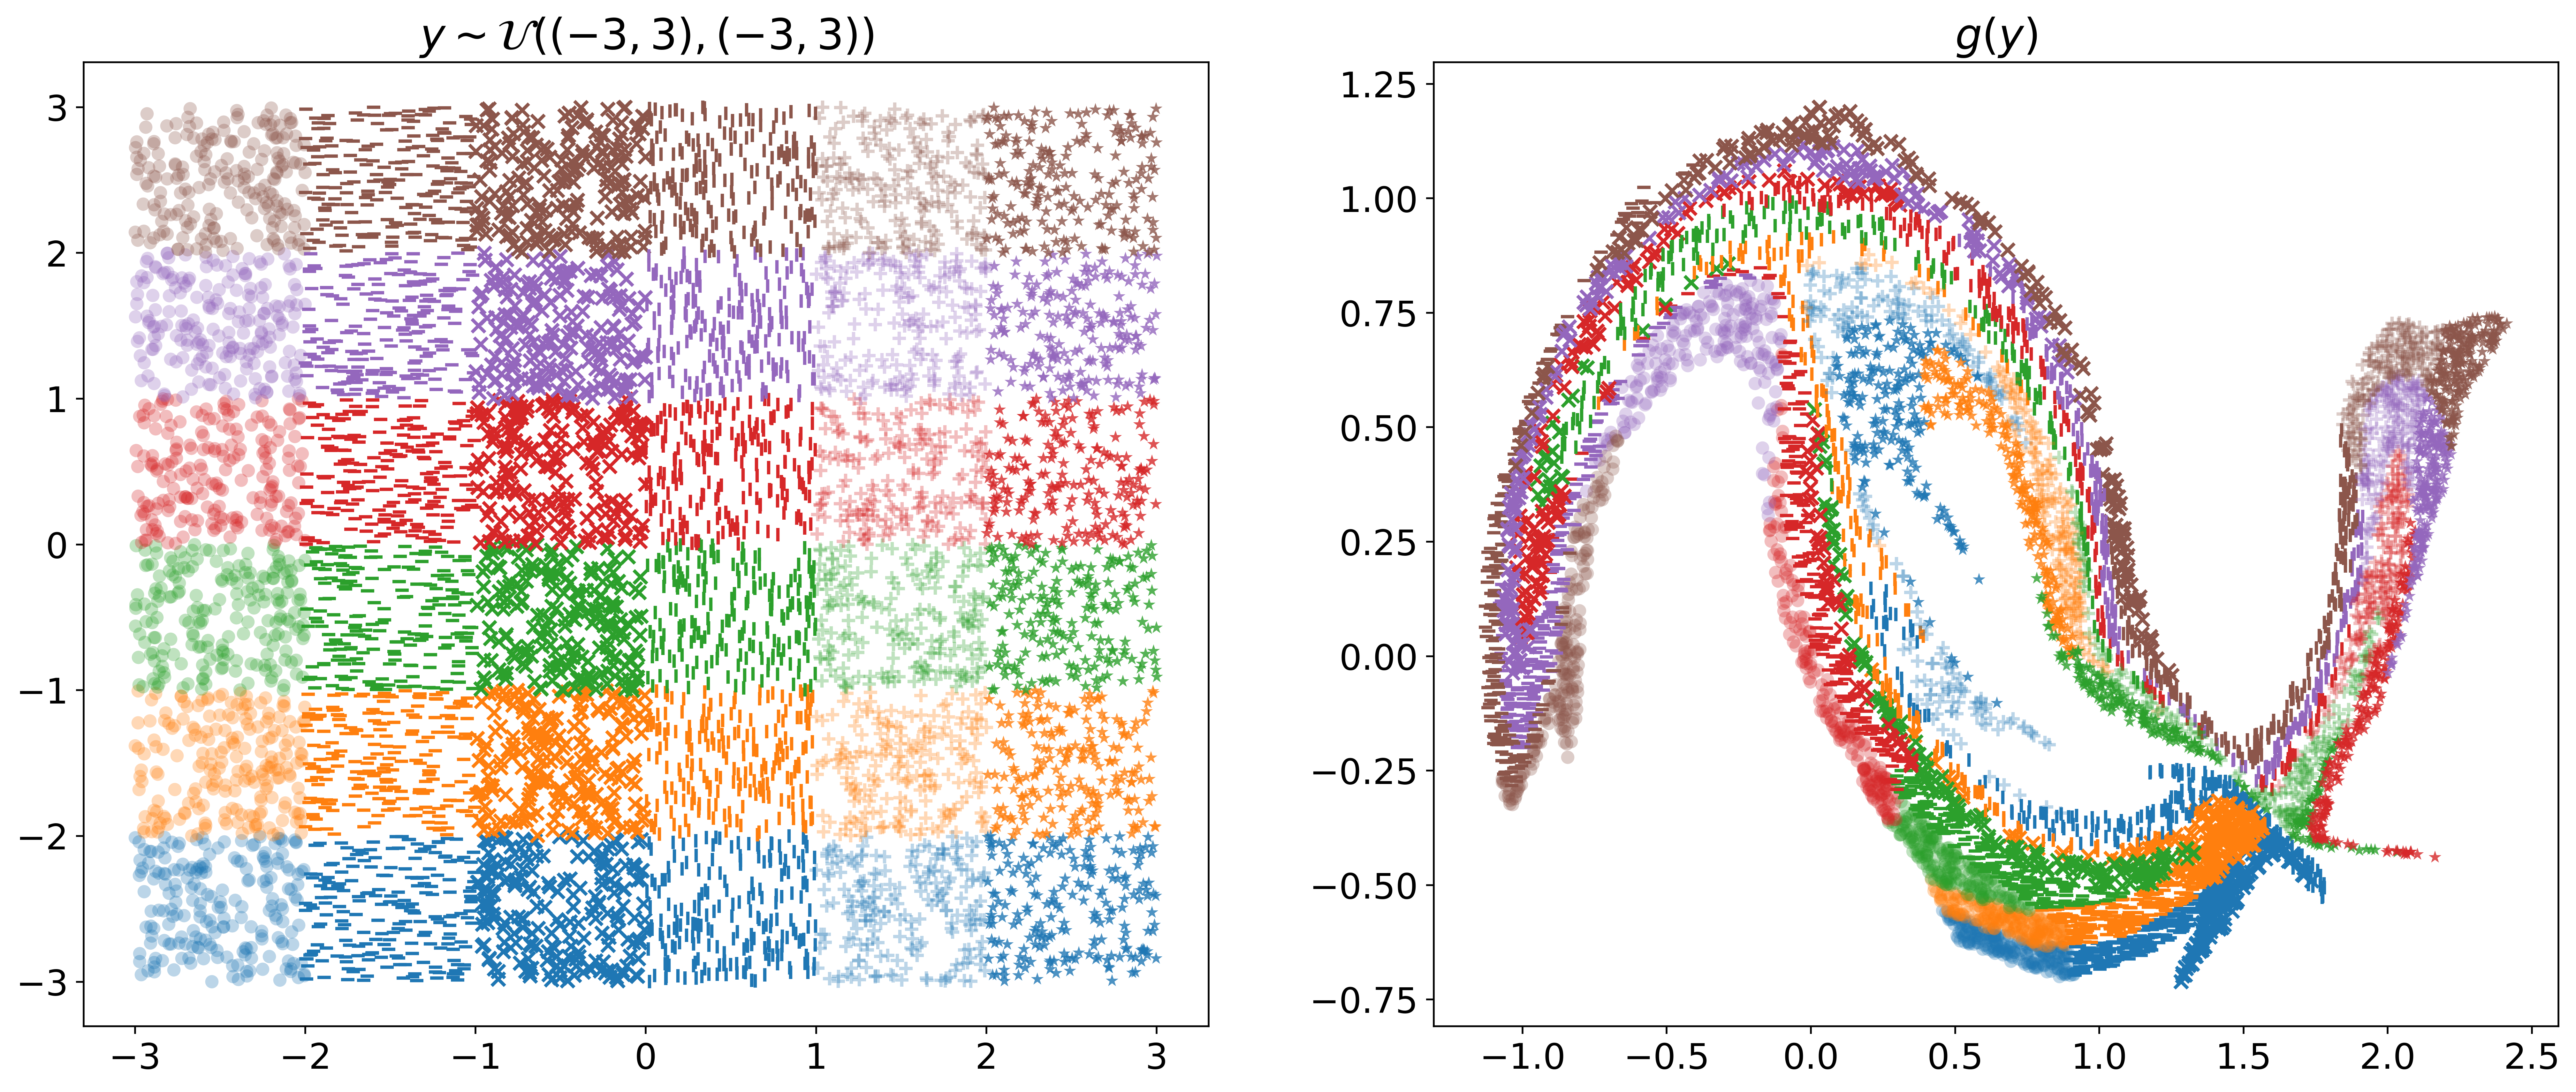

In [6]:
rcParams['figure.figsize'] = 20, 8

# Make a 6x6 grid of the latent space and sample n points unifrom in each quadrant. 
n = 200
xrange = (-3,3)
yrange = (-3,3)
cycle = 6
markers = ['o', '_', 'x', '|', '+', '*']
alphas = [0.3, 1, 1, 1, 0.3, 0.8] 
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']
block = []
xstep = (xrange[1] - xrange[0]) / cycle
ystep = (yrange[1] - yrange[0]) / cycle
for i in np.linspace(xrange[0], xrange[1]-xstep, cycle):
    for j in np.linspace(yrange[0], yrange[1]-ystep, cycle):
        block.append((torch.FloatTensor(n).uniform_(i, i+xstep),
                      torch.FloatTensor(n).uniform_(j, j+ystep))) 

# plot each quadrant in a seperate color in y direction and seprate symbol in x direction in the latent space. 
plt.subplot(121)
plt.title(r'$y \sim \mathcal{U}('+f'{xrange}'+', '+f'{yrange}'+')$')
i = 0
for x, y in block:
    plt.scatter(x, y, linewidths=0, c=colors[i%cycle], marker=markers[i//cycle], alpha=alphas[i//cycle])
    i += 1
    
# plot each quadrant in a seperate color in y direction and seprate symbol in x direction in the original space. 

plt.subplot(122)
plt.title(r'$g(y)$')
i = 0
for x, y in block:
    z = flow.g(torch.stack((x, y)).T).detach().numpy()
    plt.scatter(z[:,0], z[:,1], linewidths=0, c=colors[i%cycle], marker=markers[i//cycle], alpha=alphas[i//cycle])
    i += 1
plt.show()